# Machine learning model to read reviews

Question: how can we analyze a large number or reviews with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

In [1]:
# 1 Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

# Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# 2 Postgres username, password, and database name
POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'XXXX' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# 3 Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned''', con=cnx)
df.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...


### Prepare data for ML model

In [4]:
# 4 function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


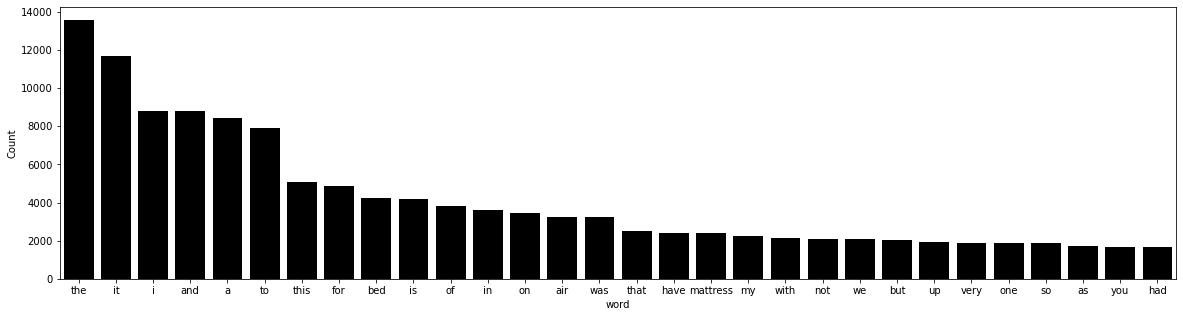

In [5]:
freq_words(df['review_body'])

In [6]:
# 5 Remove unwanted characters, numbers and symbols
df['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...
...,...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,5,good buy very little leak the bed itself is ve...,good buy very little leak the bed itself is ve...
4749,52922779,R3FMSB7NVM64SP,5,this is a great thing to have the built in pum...,this is a great thing to have the built in pum...
4750,45643821,R3JPX7JXE4JF61,5,this air mattress is incredible we bought it ...,this air mattress is incredible we bought it ...
4751,14464916,R2XZEVT9OE0BXI,4,i have not had this item for very long and hav...,i have not had this item for very long and hav...


In [7]:
# 6 Remove stop words
stop_words = nltk.corpus.stopwords.words('english')

# Remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Exclude stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# 7 To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-05-12 23:54:50.959365: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-12 23:54:50.959393: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# 8 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter adjective only
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['big', 'comfortable', 'long']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


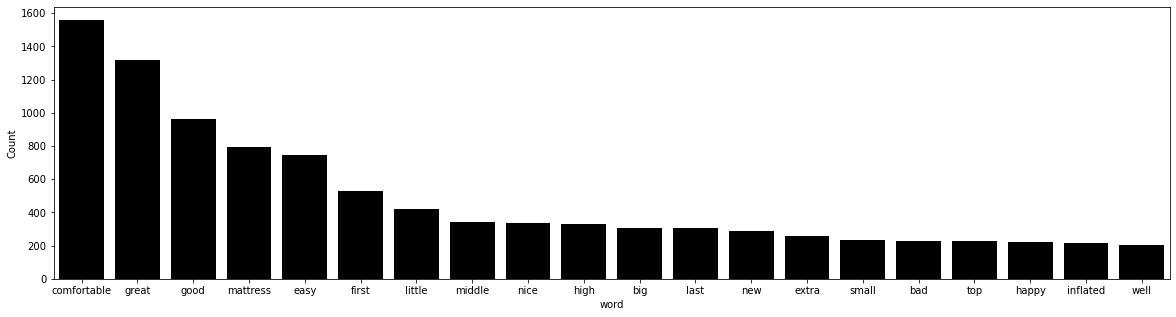

In [12]:
# 9 Show word count after reviews clean up
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)

It will be easier to understand good and bad customer feedback if we break the analysis into good reviews and bad reviews

### Develop 2 separate analysis: good reviews from bad reviews

Create 2 dataframes, one with only 1 star reviews and another with 2 star reviews to get a better sense of the good and bad feedback

In [13]:
# 10 Create df for only bad reviews, 1-star
df_1star = df[df['star_rating'] == 1]
df_1star.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body,reviews
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible was comfortable for the first few day...,horrible comfortable first first bad bad hourl...
5,11489596,R157632LYK6UT6,1,i wish i could return this item i read almost ...,wish could return this item read almost all re...,many negative arrogant prior heavy personbr
6,12256364,R2759URB10Q8RD,1,our bad experience is the same as some others ...,our bad experience the same some others have e...,bad first nice comfortable flat top able small...
12,15328213,R6ISQWC1P9QMC,1,thought this was a great choice and it was unt...,thought this was great choice and was until de...,great third middle visible
29,22202716,R383PLOVTFG353,1,ok i ordered this on november 17th 2013 and i ...,ordered this november and got couple days afte...,big middle


In [14]:
# 11 Create df for only good reviews, 5-stars
df_5stars = df[df['star_rating'] == 5]
df_5stars.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body,reviews
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,wife and had pick one these over the holiday f...,little concerned blowup first dead tired secon...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this big and comfortable inflatesdeflates itse...,big comfortable long
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,bought this our friends kids would have extra ...,extra twice last great high nice extra great
7,22867429,R238AOC9MSH1XZ,5,grandkids love this so do we it is comfortab...,grandkids love this comfortable and large enou...,comfortable large small great
8,40522779,R3BYPZR2ROSYJ5,5,enough said doesnt deflate yet at least and fe...,enough said doesnt deflate yet least and feels...,least many


In [15]:
# 12 Remove unwanted characters, numbers and symbols
df_1star['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df_5stars['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_l

In [16]:
# 13 Remove stopwords
new_stopwords = ["first", "mattress", "second", "last"]
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(new_stopwords)

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Exclude stopwords from the text
reviews_1star = [remove_stopwords(r.split()) for r in df_1star['review_body']]
reviews_5stars = [remove_stopwords(r.split()) for r in df_5stars['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# 14 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
tokenized_reviews_1star = pd.Series(reviews_1star).apply(lambda x: x.split())
tokenized_reviews_5stars = pd.Series(reviews_5stars).apply(lambda x: x.split())
print(tokenized_reviews_1star[1])
print(tokenized_reviews_5stars[1])

['wish', 'could', 'return', 'item', 'read', 'almost', 'reviews', 'making', 'purchase', 'could', 'believe', 'item', 'still', 'sold', 'amazon', 'many', 'negative', 'experiences', 'thinking', 'follow', 'instructions', 'work', 'arrogant', 'part', 'would', 'buy', 'againabsolutely', 'leakabsolutely', 'definitely', 'yes', 'could', 'even', 'use', 'one', 'night', 'leaked', 'much', 'followed', 'instructions', 'set', 'prior', 'use', 'instructed', 'point', 'seemed', 'okay', 'leaks', 'weight', 'addedeven', 'lbs', 'weight', 'even', 'take', 'heavy', 'personbr', 'choice', 'whether', 'buy', 'personally', 'would', 'touch', 'product', 'brand', 'ever', 'since', 'trust', 'anymore']
['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
reviews_1star_2 = lemmatization(tokenized_reviews_1star)
reviews_5stars_2 = lemmatization(tokenized_reviews_5stars)

print(reviews_1star_2[1]) 
print(reviews_5stars_2[1]) 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['many', 'negative', 'arrogant', 'prior', 'heavy', 'personbr']
['big', 'comfortable', 'long']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


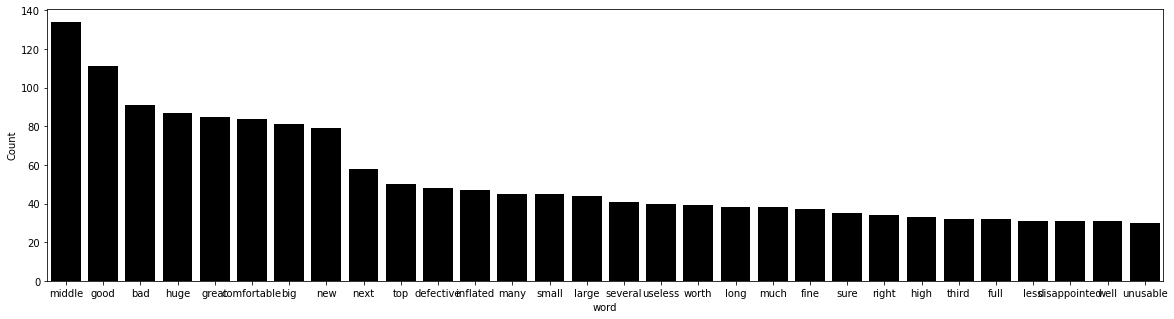

In [20]:
# 15 Create chart frequent words for 1 star reviews
reviews_1star_3 = []
for i in range(len(reviews_1star_2 )):
    reviews_1star_3.append(' '.join(reviews_1star_2[i]))

df_1star['reviews'] = reviews_1star_3

freq_words(df_1star['reviews'], 30)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


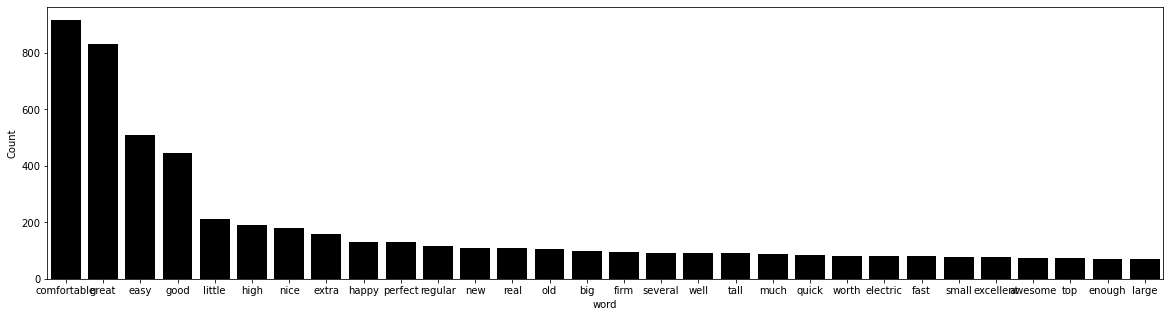

In [21]:
# 16 Create chart frequent words for 5 star reviews
reviews_5stars_3 = []
for i in range(len(reviews_5stars_2 )):
    reviews_5stars_3.append(' '.join(reviews_5stars_2[i]))

df_5stars['reviews'] = reviews_5stars_3

freq_words(df_5stars['reviews'], 30)

### Create Latent Dirichlet Allocation (LDA) model

One application of LDA in machine learning - specifically, topic discovery, a subproblem in natural language processing - is to discover topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. Souce: Wikipedia

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts. Source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [22]:
# 17 Import dependencies for LDA model
import gensim
from gensim import corpora

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.wa

In [23]:
# 18 Create the term dictionary of our corpus, unique terms are assigned an index
dictionary_1star = corpora.Dictionary(reviews_1star_2)
dictionary_5stars = corpora.Dictionary(reviews_5stars_2)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 19 Transform list of reviews into a document term matrix
doc_term_matrix_1star = [dictionary_1star.doc2bow(rev) for rev in reviews_1star_2]
doc_term_matrix_5stars = [dictionary_5stars.doc2bow(rev) for rev in reviews_5stars_2]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 20 Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model. In this case we specifified # of topics = 4 and 3 (reassessed after viz)
lda_model_1star = LDA(corpus=doc_term_matrix_1star, id2word=dictionary_1star, num_topics=4, random_state=100,
                chunksize=1000, passes=50)

lda_model_5stars = LDA(corpus=doc_term_matrix_5stars, id2word=dictionary_5stars, num_topics=3, random_state=100,
                chunksize=1000, passes=50)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# 21 Print topics 1 star
lda_model_1star.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.045*"comfortable" + 0.030*"middle" + 0.024*"long" + 0.024*"slow" + 0.021*"third" + 0.018*"bad" + 0.015*"able" + 0.014*"useless" + 0.014*"sure" + 0.013*"dissatisfied"'),
 (1,
  '0.045*"bad" + 0.043*"huge" + 0.043*"middle" + 0.036*"great" + 0.024*"worth" + 0.017*"top" + 0.016*"next" + 0.015*"many" + 0.015*"large" + 0.013*"happy"'),
 (2,
  '0.058*"good" + 0.055*"big" + 0.031*"middle" + 0.021*"next" + 0.021*"defective" + 0.020*"new" + 0.019*"inflated" + 0.014*"top" + 0.014*"high" + 0.014*"flat"'),
 (3,
  '0.029*"small" + 0.025*"new" + 0.025*"great" + 0.024*"huge" + 0.023*"well" + 0.019*"unusable" + 0.019*"comfortable" + 0.018*"cheap" + 0.018*"right" + 0.016*"much"')]

In [27]:
# 22 Print topics 5 stars
lda_model_5stars.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.080*"comfortable" + 0.043*"happy" + 0.041*"new" + 0.039*"regular" + 0.024*"long" + 0.024*"much" + 0.020*"old" + 0.019*"worth" + 0.018*"extra" + 0.017*"little"'),
 (1,
  '0.169*"comfortable" + 0.092*"easy" + 0.034*"good" + 0.034*"perfect" + 0.026*"electric" + 0.020*"many" + 0.019*"excellent" + 0.016*"spare" + 0.016*"extra" + 0.016*"several"'),
 (2,
  '0.170*"great" + 0.064*"good" + 0.041*"easy" + 0.038*"little" + 0.031*"nice" + 0.031*"high" + 0.022*"real" + 0.017*"enough" + 0.014*"cold" + 0.014*"small"')]

### Topics visualization

In [28]:
# 23 Visualize topics for 1 star
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_1star, doc_term_matrix_1star, dictionary_1star)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.018223 -0.136554       1        1  29.811810
3     -0.080525  0.107375       2        1  27.706949
1     -0.087521 -0.028495       3        1  23.549490
0      0.149824  0.057674       4        1  18.931750, topic_info=            Term       Freq      Total Category  logprob  loglift
16           big  69.000000  69.000000  Default  30.0000  30.0000
47          good  94.000000  94.000000  Default  29.0000  29.0000
63          huge  73.000000  73.000000  Default  28.0000  28.0000
2    comfortable  71.000000  71.000000  Default  27.0000  27.0000
23         small  39.000000  39.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
52      inflated   6.424768  40.310056   Topic4  -4.7859  -0.1721
44         large   6.123616  37.791910   Topic4  -4.8339  -0.1556
139         easy   4.991790  13.464851   Topic4  -5.0383   0.6720
233         high   5.544110  28.606988   Topic4  -4.9333   0.0234
23         small   5.543074  39.035037   Topic4  -4.9335  -0.2876

[260 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
15        3  0.400215        able
15        4  0.550296        able
696       2  0.786630  acceptable
194       3  0.945882      airbed
400       4  0.797116     annoyed
...     ...       ...         ...
262       1  0.298294   wonderful
262       4  0.596588   wonderful
97        3  0.691503       worth
97        4  0.300653       worth
308       3  0.799982      zerobr

[352 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [29]:
# 23.1 Export to html
lda_model_1star=open('lda_model_1star.html', 'w')
pyLDAvis.save_html(vis, lda_model_1star)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# 24 Visualize topics for 5 stars
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_5stars, doc_term_matrix_5stars, dictionary_5stars)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.210500 -0.078416       1        1  41.173000
1      0.177814 -0.131400       2        1  31.479517
0      0.032686  0.209816       3        1  27.347483, topic_info=            Term        Freq       Total Category  logprob  loglift
21         great  706.000000  706.000000  Default  30.0000  30.0000
18   comfortable  806.000000  806.000000  Default  29.0000  29.0000
47          easy  463.000000  463.000000  Default  28.0000  28.0000
5          happy  119.000000  119.000000  Default  27.0000  27.0000
40           new  114.000000  114.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
117          top   25.269207   61.224272   Topic3  -4.6950   0.4116
83          fast   23.976053   69.078328   Topic3  -4.7475   0.2384
23          nice   28.791066  157.711265   Topic3  -4.5645  -0.4042
38          good   31.661201  408.576965   Topic3  -4.4694  -1.2610
29          full   22.185360   55.436508   Topic3  -4.8251   0.3807

[180 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
93        1  0.247983        able
93        2  0.181854        able
93        3  0.578628        able
279       1  0.995757  additional
148       3  0.925273      amazed
...     ...       ...         ...
82        3  0.444703        well
143       1  0.983066       whole
94        1  0.977438   wonderful
33        2  0.331234       worth
33        3  0.675208       worth

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [31]:
# 24.1 Export to html
lda_model_5stars=open('5star_lda.html', 'w')
pyLDAvis.save_html(vis, lda_model_5stars)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 28215 words in the combination of all cells in column reviews for 1-star.


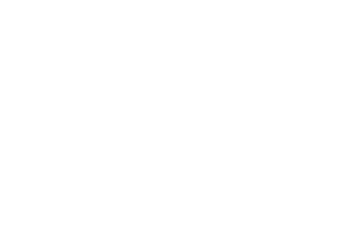

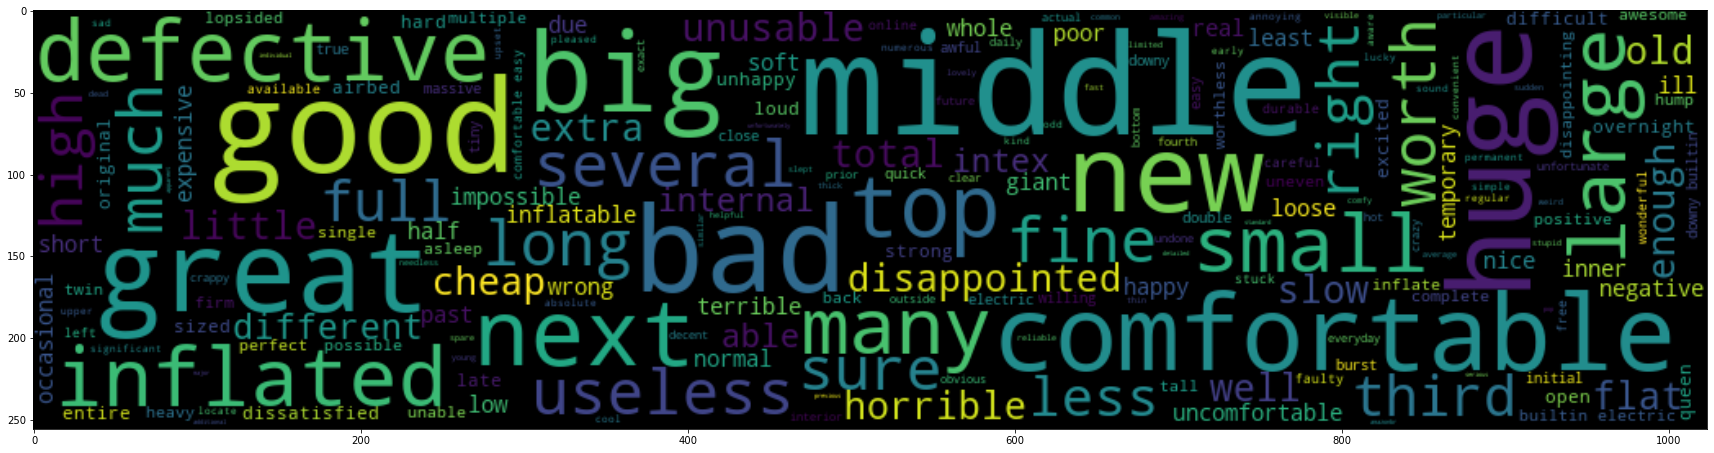

In [32]:
# 25 Create word cloud for 5 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_1star.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="black", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 71480 words in the combination of all cells in column reviews for 1-star.


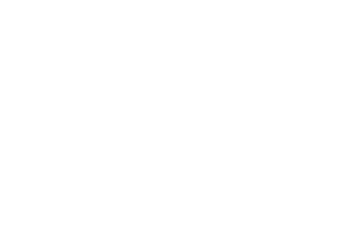

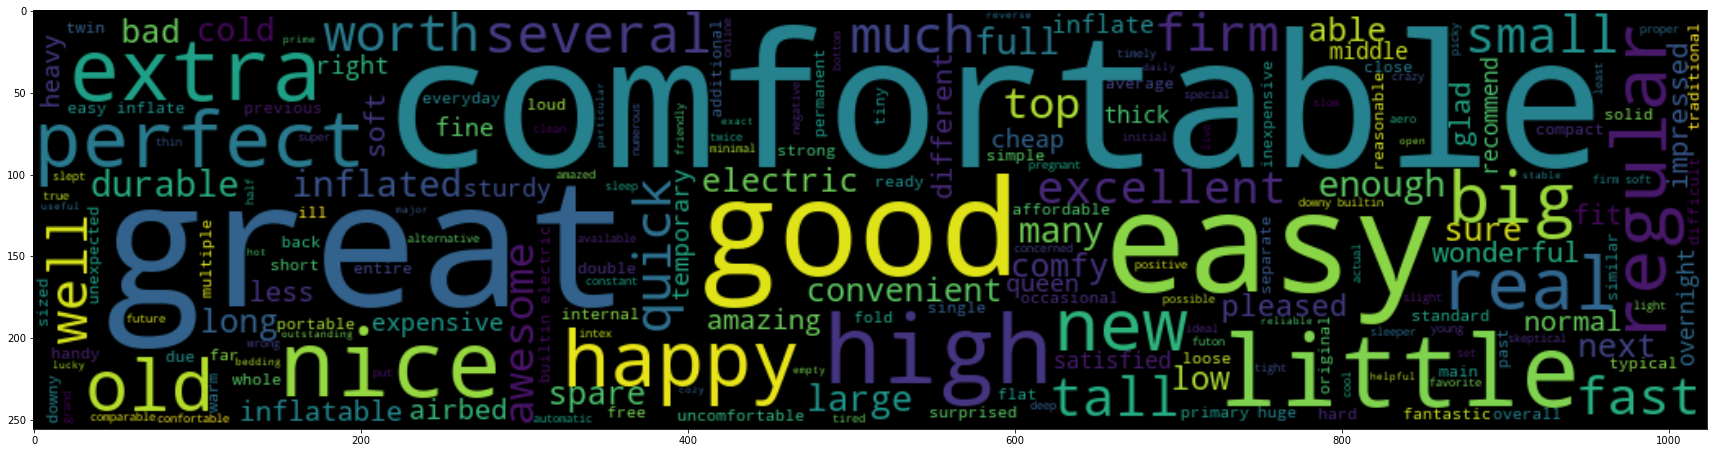

In [33]:
# 26 Create word cloud for 5 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_5stars.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="black", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()